In [2]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

from game_utils.ContinuousPokerVariants.LCP import LCP, LCP_utils


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _ARRAY_API not found

In [12]:
from sympy import symbols, Rational, Function, sqrt, diff, lambdify, simplify


class LCPSymbolicExprs:
    # Define symbolic variables
    x, L, U = symbols('x L U')
    x0, x1, x2, x3, x4, x5 = symbols('x0 x1 x2 x3 x4 x5')
    s, c = symbols('s c')

    # Define A0 to A5 expressions
    A0 = U**2 + 3*U + 3
    A1 = 7*U**3 + 21*U**2 + 21*U + 6
    A2 = 6*U**3 + 18*U**2 + 18*U + 5
    A3 = 7*U**3 + 21*U**2 + 18*U + 3
    A4 = 3*A1*L**2 + 3*A1*L + A1 + A2*L**3
    A5 = 3*A0*L**2*U + 3*A0*L*U + A0*U - L**3

    # Define x0 to x5 expressions
    x0_def = (3*(L + 1)**3*U)/A4
    x1_def = (3*A0*L*U + A0*U - L**3 - 3*L**2)/A4
    x2_def = A5/A4
    x3_def = (A2*L**3 + 3*A2*L**2 + 3*L*(5*U**3 + 15*U**2 + 15*U + 4) + 4*U**3 + 12*U**2 + 12*U + 3)/A4
    x4_def = (3*A1*L**2 + A2*L**3 + 3*A2*L + 4*U**3 + 12*U**2 + 12*U + 3)/A4
    x5_def = (3*A3*L**2 + 3*A3*L + A3 + L**3*(6*U**3 + 18*U**2 + 15*U + 2))/A4
    b0_def = -(L + 1)**3/A4

    # Define other expressions
    vinv = -1 - sqrt((4*x - 4)*(-2 + 2*x2))/(4*x - 4)
    c_def = (s + x2)/(s + 1)
    EV = 1/2 * c + (x - c) * (s + 1/2) + (1 - x) * (-s - 1/2)
    EV_U = EV.subs(c, c_def).subs(s, U).subs(x2, x2_def)
    EV_vinv = EV.subs(c, c_def).subs(s, vinv).subs(x2, x2_def)

    dx2dU = diff(x2_def, U)

    # Compute derivatives for dEVdU
    dEVdU_U = diff(EV_U, U)
    dEVdU_vinv = diff(EV_vinv, U)
    residual = -dx2dU * U/(1+U)

    # Create lambda functions
    x5_lambda = lambdify((L, U), x5_def, 'numpy')
    EV_lambda_U = lambdify((x, L, U), EV_U, 'numpy')
    EV_lambda_vinv = lambdify((x, L, U), EV_vinv, 'numpy')
    dEVdU_lambda_U = lambdify((x, L, U), dEVdU_U, 'numpy')
    dEVdU_lambda_vinv = lambdify((x, L, U), dEVdU_vinv, 'numpy')
    residual_lambda = lambdify((x, L, U), residual, 'numpy')

    @staticmethod
    def compute_EV(x, L, U):
        if x >= LCPSymbolicExprs.x5_lambda(L, U):
            return LCPSymbolicExprs.EV_lambda_U(x, L, U)
        else:
            return LCPSymbolicExprs.EV_lambda_vinv(x, L, U)

    @staticmethod
    def compute_dEVdU(x, L, U):
        if x >= LCPSymbolicExprs.x5_lambda(L, U):
            return LCPSymbolicExprs.dEVdU_lambda_U(x, L, U)
        else:
            return LCPSymbolicExprs.dEVdU_lambda_vinv(x, L, U)


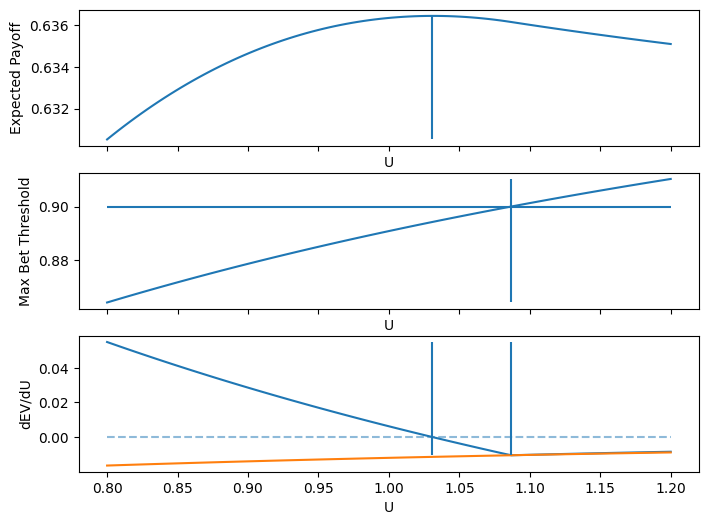

In [34]:
# plot EV(x) for a fixed x as a function of U
Ulims=(0.8, 1.2)
L=0
x = 0.9
U_vals = np.linspace(Ulims[0], Ulims[1], 100)
EVs = np.zeros_like(U_vals)
dEVdUs = np.zeros_like(U_vals)
max_ths = np.zeros_like(U_vals)
residuals = np.zeros_like(U_vals)
for i, U in enumerate(U_vals):
    game_params = {"L": L, "U": U}
    EVs[i] = LCPSymbolicExprs.compute_EV(x, L, U)
    dEVdUs[i] = LCPSymbolicExprs.compute_dEVdU(x, L, U)
    max_ths[i] = LCP_utils.compute_x5(game_params)
    residuals[i] = LCPSymbolicExprs.residual_lambda(x, L, U)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

ax1.plot(U_vals, EVs)
ax1.vlines([U_vals[np.argmax(EVs)]], min(EVs), max(EVs))
ax1.set_ylabel('Expected Payoff')
ax1.set_xlabel('U')

ax2.plot(U_vals, max_ths)
ax2.hlines([x], Ulims[0], Ulims[1])
ax2.vlines([U_vals[np.argmin(np.abs(x-max_ths))]], min(max_ths), max(max_ths))
ax2.set_xlabel('U')
ax2.set_ylabel('Max Bet Threshold')

ax3.plot(U_vals, dEVdUs)
ax3.plot(U_vals, residuals)
ax3.vlines([U_vals[np.argmin(np.abs(dEVdUs))], U_vals[np.argmin(dEVdUs)]], min(dEVdUs), max(dEVdUs))
ax3.set_xlabel('U')
ax3.hlines(0, Ulims[0], Ulims[1], linestyles='dashed', alpha=0.5)

ax3.set_ylabel('dEV/dU')


plt.show()


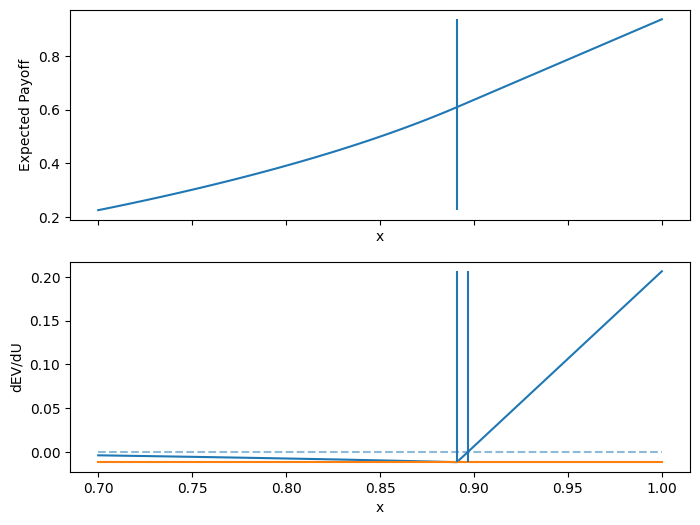

In [20]:
# plot EV(x) for a fixed U as a function of x
xlims = (0.7, 1)
L = 0
U = 1 # Fixed U value
x_vals = np.linspace(xlims[0], xlims[1], 100)
EVs = np.zeros_like(x_vals)
dEVdUs = np.zeros_like(x_vals)
residuals = np.zeros_like(x_vals)

game_params = {"L": L, "U": U}
max_th = LCP_utils.compute_x5(game_params)

for i, x in enumerate(x_vals):
    EVs[i] = LCPSymbolicExprs.compute_EV(x, L, U)
    dEVdUs[i] = LCPSymbolicExprs.compute_dEVdU(x, L, U)
    residuals[i] = LCPSymbolicExprs.residual_lambda(x, L, U)


fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax1.plot(x_vals, EVs)
ax1.vlines([max_th], min(EVs), max(EVs))
ax1.set_ylabel('Expected Payoff')
ax1.set_xlabel('x')


ax3.plot(x_vals, dEVdUs)
ax3.plot(x_vals, residuals)
ax3.vlines([x_vals[np.argmin(np.abs(dEVdUs))], x_vals[np.argmin(dEVdUs)]], min(dEVdUs), max(dEVdUs))
ax3.set_xlabel('x')
ax3.hlines(0, xlims[0], xlims[1], linestyles='dashed', alpha=0.5)
ax3.set_ylabel('dEV/dU')

plt.show()


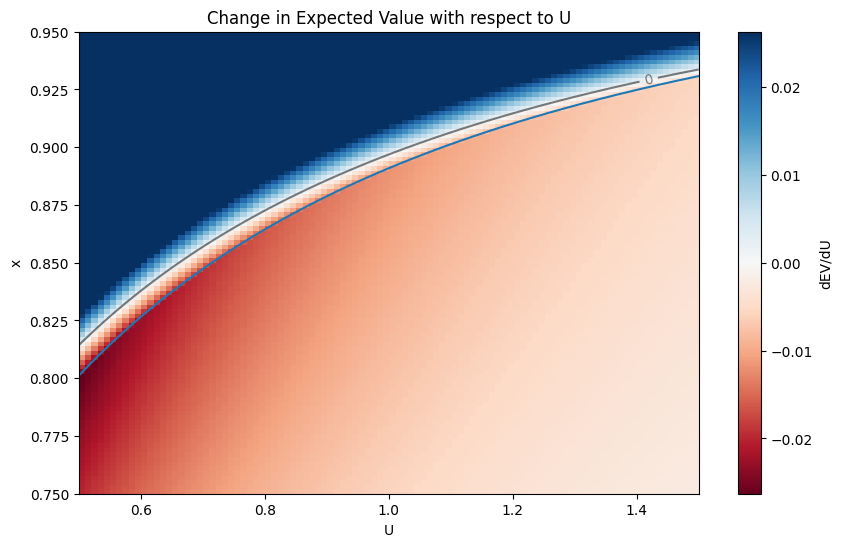

In [27]:
# Create heatmap of dEV/dU as a function of x and U
x_vals = np.linspace(0.75, .95, 100)  # Using same x range as above
U_vals = np.linspace(0.5, 1.5, 100)  # Range of U values to explore
L = 0  # Fixed L value

# Initialize array to store dEV/dU values
dEVdU_grid = np.zeros((len(x_vals), len(U_vals)))

# Compute dEV/dU for each (x,U) pair
for i, x in enumerate(x_vals):
    for j, U in enumerate(U_vals):
        dEVdU_grid[i,j] = LCPSymbolicExprs.compute_dEVdU(x, L, U)

# Find minimum value and cap at its absolute value
min_val = np.min(dEVdU_grid)
cap_val = abs(min_val)
dEVdU_grid = np.clip(dEVdU_grid, -cap_val, cap_val)

# Create heatmap
plt.figure(figsize=(10, 6))
plt.imshow(dEVdU_grid, 
          aspect='auto',
          extent=[U_vals[0], U_vals[-1], x_vals[0], x_vals[-1]],
          origin='lower',
          cmap='RdBu',
          vmin=-cap_val,  # Center colormap at 0
          vmax=cap_val)

plt.colorbar(label='dEV/dU')
plt.xlabel('U')
plt.ylabel('x')
plt.title('Change in Expected Value with respect to U')

# Add contour line at dEV/dU = 0
CS = plt.contour(U_vals, x_vals, dEVdU_grid, levels=[0], colors='black', alpha=0.5)
plt.clabel(CS, inline=True, fontsize=10)


max_ths = [LCP_utils.compute_x5({"U": U, "L": L}) for U in U_vals]
plt.plot(U_vals, max_ths)

plt.show()
